## **Импорты**

In [ ]:
from google.colab import drive
import shutil

import requests
from bs4 import BeautifulSoup

import time
import pandas as pd
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import RegexpTokenizer


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## **Парсинг**

In [ ]:
def process_pages():
    reviews = []
    ratings = []
    dates = []
    for star in range(1, 6):
      for page_number in range(2, 28):
          print(f"Processing page number: {page_number-1} out of 25 with star = {star} ... {len(dates)+20}, {len(reviews)+20}, {len(ratings)+20}")
          len_time = len(reviews)
          r = requests.get(f'https://www.trustpilot.com/review/westernunion.com?page={page_number}&stars={star}')
          soup = BeautifulSoup(r.text, "html.parser")

          reviews_html = soup.find_all("div", class_="styles_reviewContent__0Q2Tg")
          reviews += [review_html.get_text() for review_html in reviews_html]

          ratings += [rating.get('data-service-review-rating') for rating in soup.find_all("div", class_="styles_reviewHeader__iU9Px")]

          dates_html = soup.find_all("p", class_="typography_body-m__xgxZ_ typography_appearance-default__AAY17")
          dates += [dates.text for dates in dates_html if 'Date of experience:' in dates.text]

          if len(reviews) == len_time:
            break

          if len(reviews) % 1000 == 0 and len(reviews) !=20:
            time.sleep(30)

    return dates, reviews, ratings

dates, reviews, ratings = process_pages()

Processing page number: 1 out of 25 with star = 1 ... 20, 20, 20
Processing page number: 2 out of 25 with star = 1 ... 40, 40, 40
Processing page number: 3 out of 25 with star = 1 ... 60, 60, 60
Processing page number: 4 out of 25 with star = 1 ... 80, 80, 80
Processing page number: 5 out of 25 with star = 1 ... 100, 100, 100
Processing page number: 6 out of 25 with star = 1 ... 120, 120, 120
Processing page number: 7 out of 25 with star = 1 ... 140, 140, 140
Processing page number: 8 out of 25 with star = 1 ... 160, 160, 160
Processing page number: 9 out of 25 with star = 1 ... 180, 180, 180
Processing page number: 10 out of 25 with star = 1 ... 200, 200, 200
Processing page number: 11 out of 25 with star = 1 ... 220, 220, 220
Processing page number: 12 out of 25 with star = 1 ... 240, 240, 240
Processing page number: 13 out of 25 with star = 1 ... 260, 260, 260
Processing page number: 14 out of 25 with star = 1 ... 280, 280, 280
Processing page number: 15 out of 25 with star = 1 ... 

In [ ]:
len(dates), len(reviews), len(ratings)

(2600, 2600, 2600)

In [ ]:
df = pd.DataFrame(data={'date': dates, 'review': reviews, 'target':ratings})
display(df.head())

,date,review,target
0,"Date of experience: September 04, 2022",Very poor customer serviceVery poor customer s...,1
1,"Date of experience: August 13, 2023",Your app's functionality to redeem…Your app's ...,1
2,"Date of experience: September 01, 2023",WU has been obnoxious about money…WU has been ...,1
3,"Date of experience: August 01, 2023",After I sent the moneyAfter I sent the money. ...,1
4,"Date of experience: August 06, 2023",Money lostOn 08/16 I send money to Mexico. Alt...,1


## **Анализ набора данных**

In [ ]:
df['date'] = df['date'].apply(lambda date: date.split(': ')[1].replace(',', ''))
df.head()

,date,review,target
0,September 04 2022,Very poor customer serviceVery poor customer s...,1
1,August 13 2023,Your app's functionality to redeem…Your app's ...,1
2,September 01 2023,WU has been obnoxious about money…WU has been ...,1
3,August 01 2023,After I sent the moneyAfter I sent the money. ...,1
4,August 06 2023,Money lostOn 08/16 I send money to Mexico. Alt...,1


In [ ]:
# Подключение диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Выгрузка файла на диск
df.to_csv("reviews.csv", index=False)
shutil.copy("reviews.csv", "/content/drive/MyDrive/")

'/content/drive/MyDrive/reviews.csv'

In [ ]:
# Загрузка файла с диск
df = pd.read_csv("/content/drive/MyDrive/reviews.csv")
df.head()

,date,review,target
0,September 04 2022,Very poor customer serviceVery poor customer s...,1
1,August 13 2023,Your app's functionality to redeem…Your app's ...,1
2,September 01 2023,WU has been obnoxious about money…WU has been ...,1
3,August 01 2023,After I sent the moneyAfter I sent the money. ...,1
4,August 06 2023,Money lostOn 08/16 I send money to Mexico. Alt...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2600 non-null   object
 1   review  2600 non-null   object
 2   target  2600 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 61.1+ KB


Non значения отсутствуют

In [ ]:
df.describe(include=['O'])

,date,review
count,2600,2600
unique,276,2600
top,September 07 2023,Very poor customer serviceVery poor customer s...
freq,132,1


Значения уникальны, non значений нет, при этом больше всего отзывов было отсавлено 7 Сентября

In [ ]:
# Разделим дату на 3 части
df[['month', 'day', 'year']] = df["date"].str.split(' ', expand=True)
df = df.drop(columns=['date'])

In [ ]:
df.describe(include=['O'])

,review,month,day,year
count,2600,2600,2600,2600
unique,2600,12,31,2
top,Very poor customer serviceVery poor customer s...,August,07,2023
freq,1,821,212,2556


Больше всего отзывов было оставлено в Август, а также в 2023 году, при этом в выборке всего 2 года: 2023 и 2022

In [ ]:
# Стандартизируем наши данные
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"\s+", " ")
    df[text_field] = df[text_field].str.lower()
    return df


clean_data = standardize_text(df, "review")

In [ ]:
clean_data.head()

,review,target,month,day,year
0,very poor customer servicevery poor customer s...,1,September,04,2022
1,your app's functionality to redeem your app's ...,1,August,13,2023
2,wu has been obnoxious about money wu has been ...,1,September,01,2023
3,after i sent the moneyafter i sent the money i...,1,August,01,2023
4,money loston 08 16 i send money to mexico alth...,1,August,06,2023


In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2600 non-null   object
 1   target  2600 non-null   int64 
 2   month   2600 non-null   object
 3   day     2600 non-null   object
 4   year    2600 non-null   object
dtypes: int64(1), object(4)
memory usage: 101.7+ KB


In [ ]:
# Токенизируем наши данные
tokenizer = RegexpTokenizer(r'\w+')

clean_data["tokens"] = clean_data.review.apply(tokenizer.tokenize)
clean_data.head()

,review,target,month,day,year,tokens
0,very poor customer servicevery poor customer s...,1,September,04,2022,"[very, poor, customer, servicevery, poor, cust..."
1,your app's functionality to redeem your app's ...,1,August,13,2023,"[your, app, s, functionality, to, redeem, your..."
2,wu has been obnoxious about money wu has been ...,1,September,01,2023,"[wu, has, been, obnoxious, about, money, wu, h..."
3,after i sent the moneyafter i sent the money i...,1,August,01,2023,"[after, i, sent, the, moneyafter, i, sent, the..."
4,money loston 08 16 i send money to mexico alth...,1,August,06,2023,"[money, loston, 08, 16, i, send, money, to, me..."


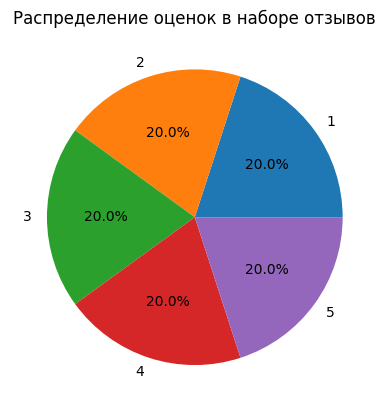

In [ ]:
estimate_counts = clean_data["target"].value_counts()

plt.pie(estimate_counts, labels=estimate_counts.index, autopct='%1.1f%%')
plt.title('Распределение оценок в наборе отзывов')
plt.show()

Классы имеют одинаковое распределение

Max length: 490
Min length: 6


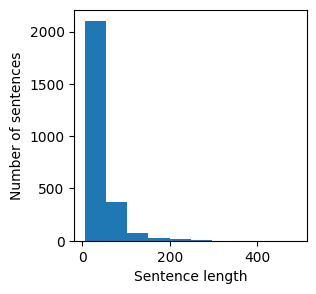

In [ ]:
sentence_lengths = [len(tokens) for tokens in clean_data['tokens']]
print(f"Max length: {max(sentence_lengths)}\nMin length: {min(sentence_lengths)}")
fig = plt.figure(figsize=(3, 3))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

Итоги по данным:
*   Пропусков нет
*   Все значения уникальны
*   Больше всего отзывов с количеством слов до 50
*   Выбросы не обнаружены
*   Классы сбалансированы
*   Можно построить задачу на 3-х предметных областях:
  1.   Оценка работы трансферной компании в 2022 и 2023 год
  2.   Оценка работы трансферной компании в разные сезоны/разные месяцы
  3.   Построение модели, которая будет предсказывать поставленную оценку по отзыву

Было выполнено/проведено:
*   Разделение даты на три группы (месяц, день год)
*   Стандартизация данных
*   Токенизация предложений
*   Анализ предметной области











## **Исследование данных**

<ipython-input-124-f7374a5c66cc>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_relation = df.groupby(['year']).mean()


<Axes: xlabel='year'>

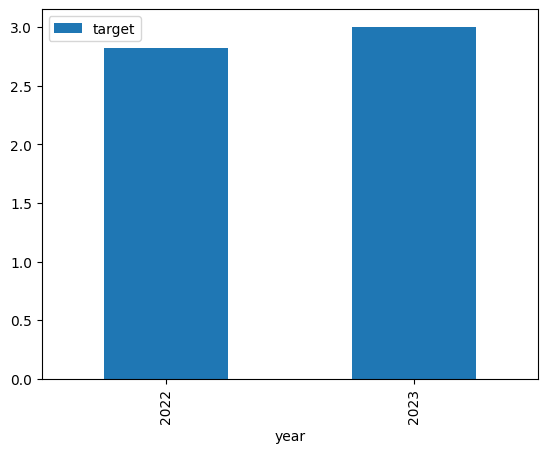

In [ ]:
# Оцека работы доставочной компании в 2022 и 2023 год
year_relation = df.groupby(['year']).mean()
year_relation.plot.bar()

На графике выше можем заметить, что качество обслуживания трансферной компании возрасло, следовательно меры, которые были нацелены на улучшение показателей в 2023 году частично оправдались

<ipython-input-125-12ab31412553>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  month_relation = df.groupby(['month']).mean()


<Axes: xlabel='month'>

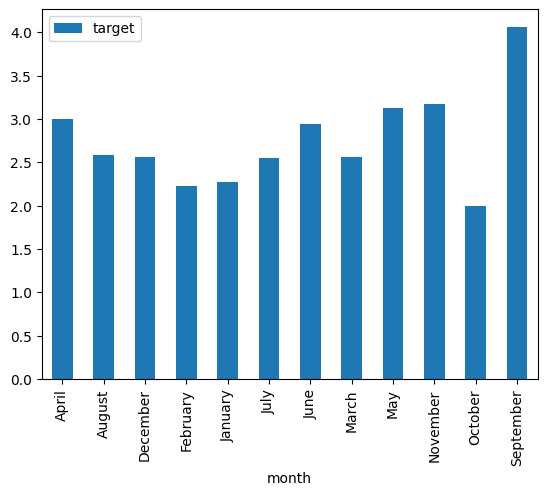

In [ ]:
month_relation = df.groupby(['month']).mean()
month_relation.plot.bar()

На графике выше видно, что самым хорошим месяцем для трансферной компании является сентрябрь, при этом в Октябре рейтинг в 2 раза хуже. Следовательно компании стоит обратить внимание на детали, и улучшить качество работы сотрудников в этом месяце

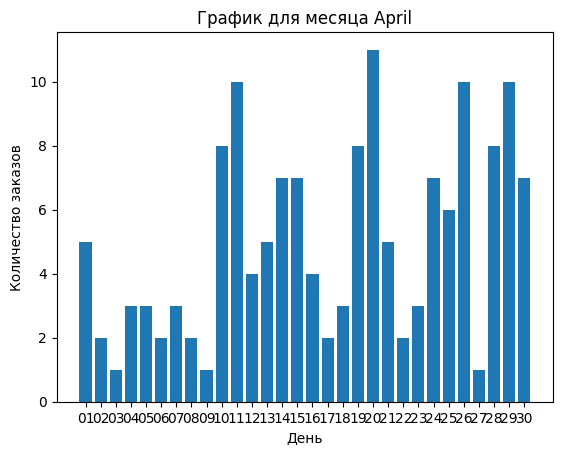

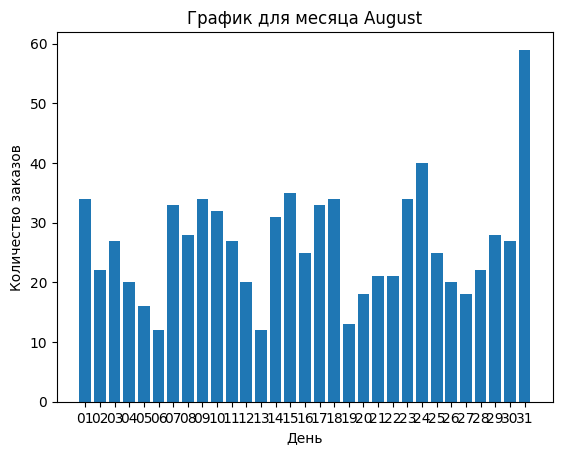

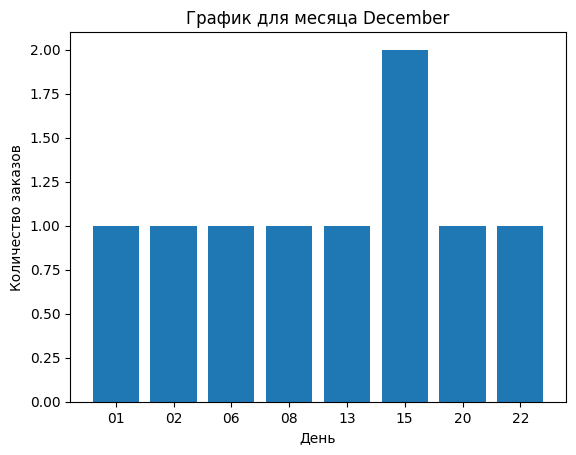

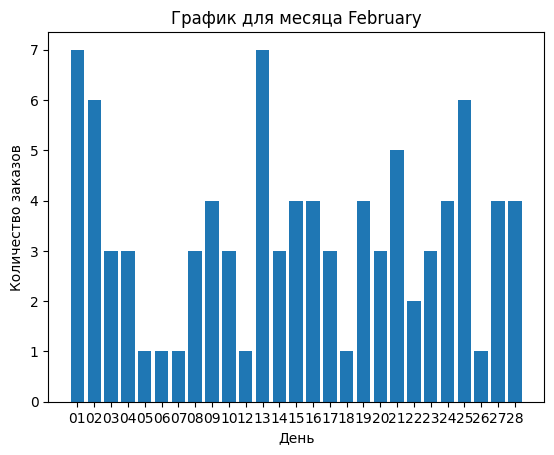

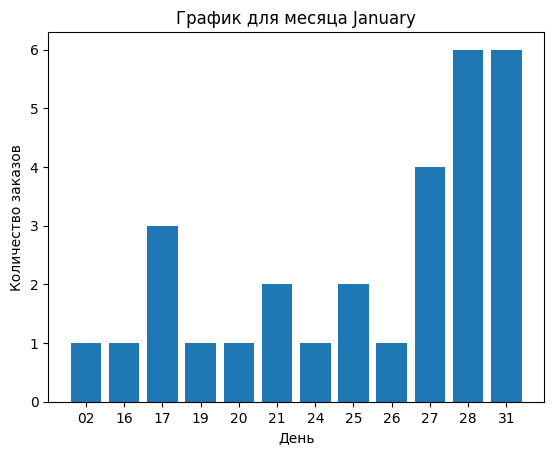

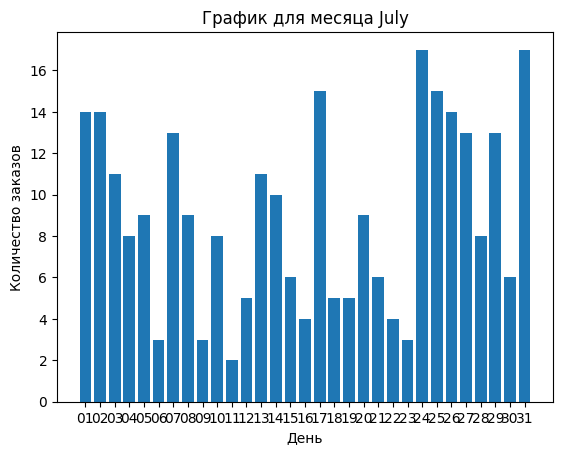

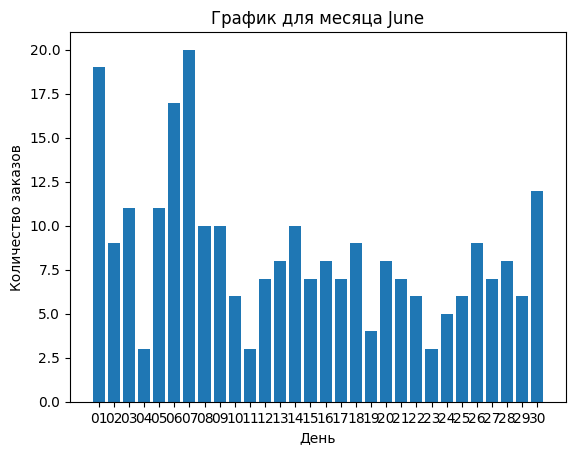

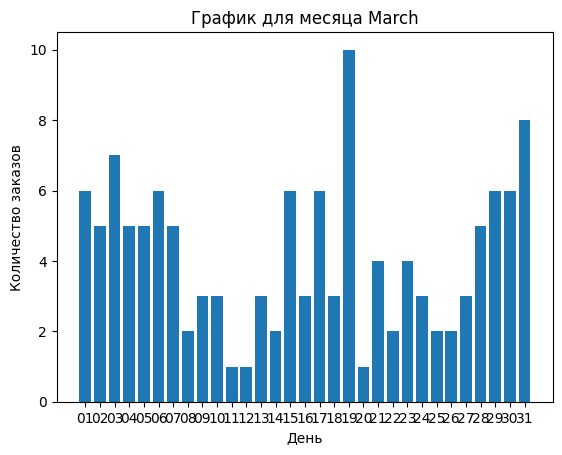

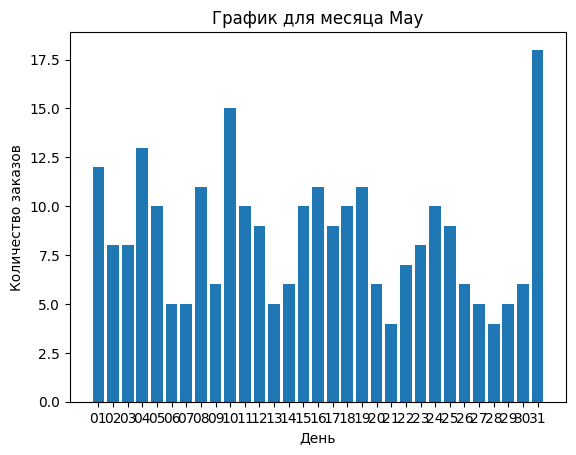

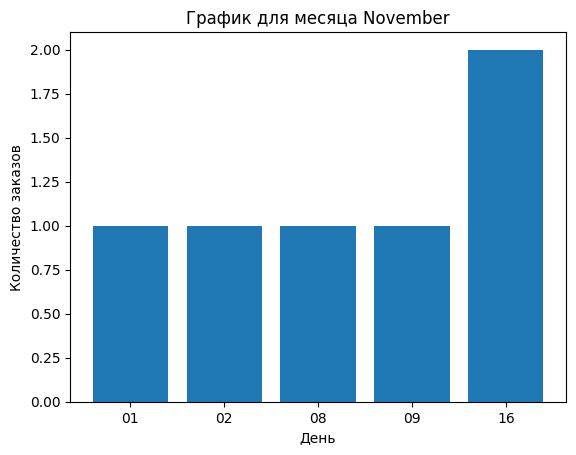

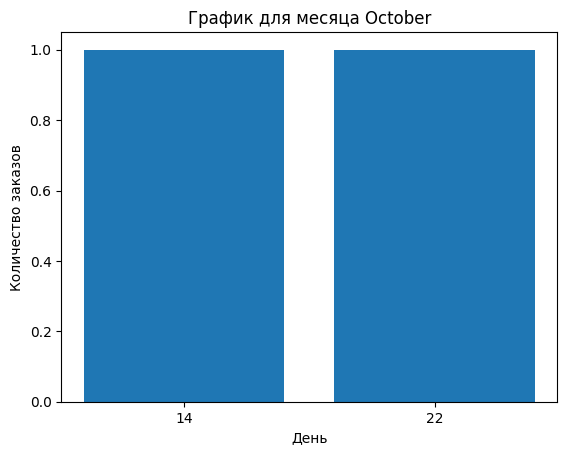

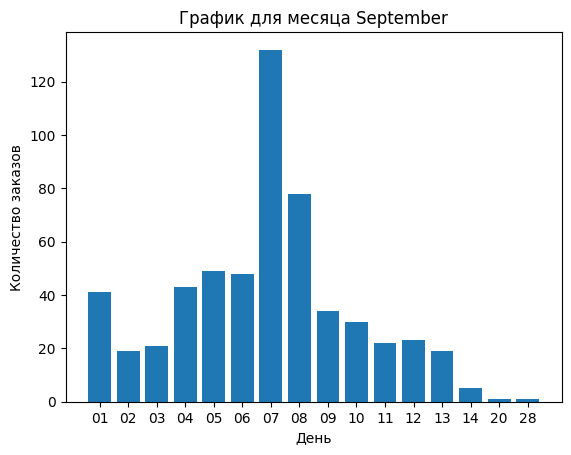

In [ ]:
grouped_data = df.groupby('month')

for month, data in grouped_data:
    daily_mean = data.groupby('day')['target'].count()

    plt.bar(daily_mean.index, daily_mean.values)

    plt.xlabel('День')
    plt.ylabel('Количество заказов')
    plt.title(f'График для месяца {month}')

    plt.show()

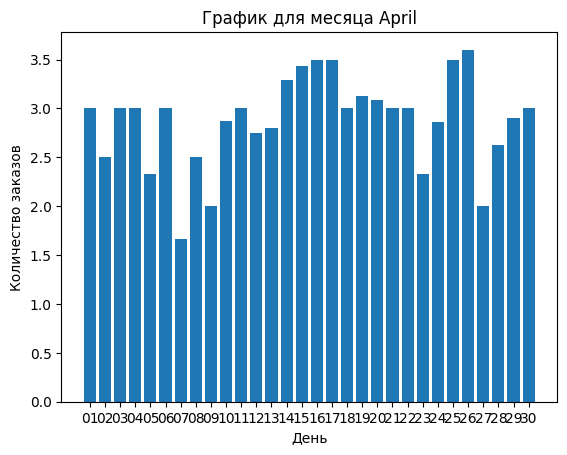

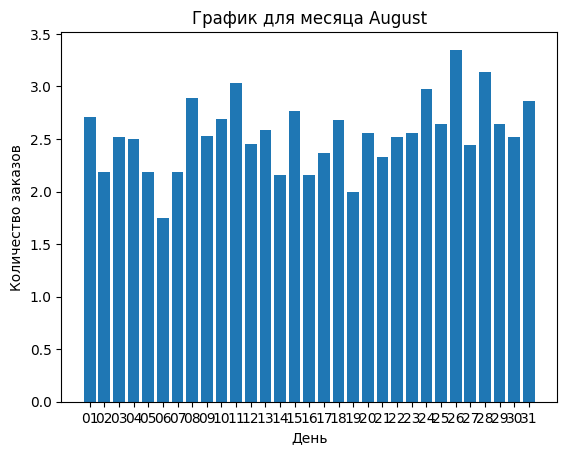

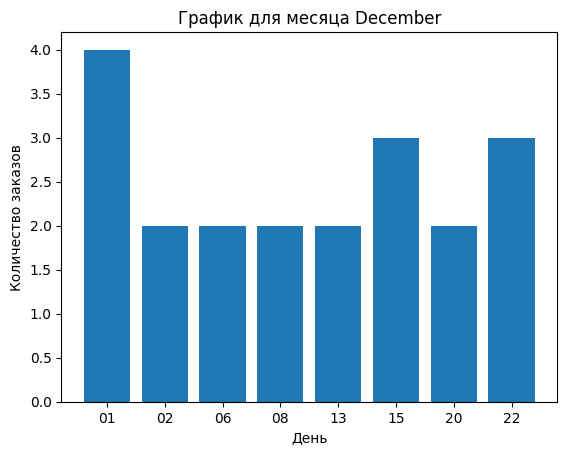

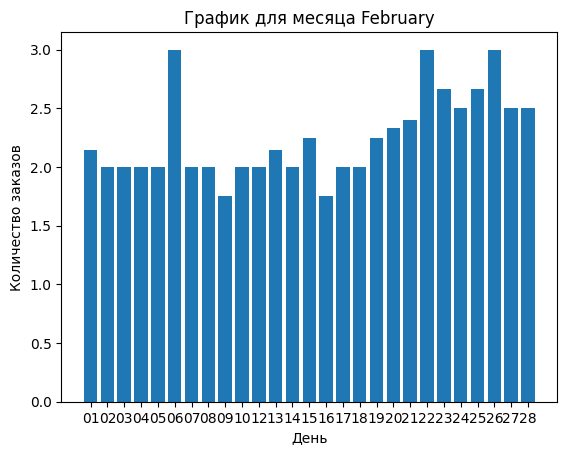

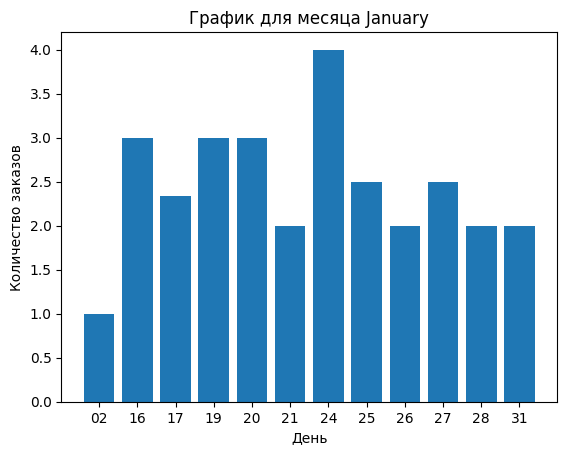

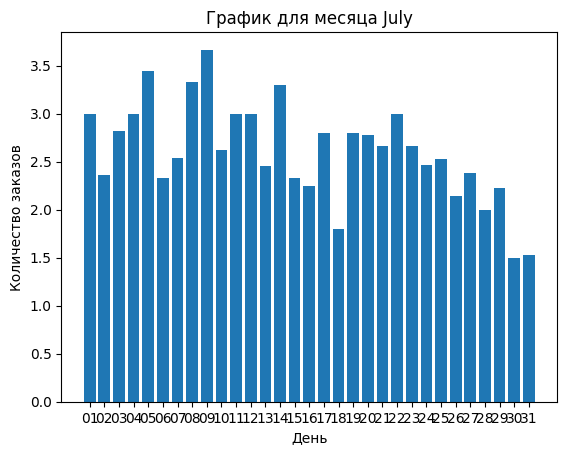

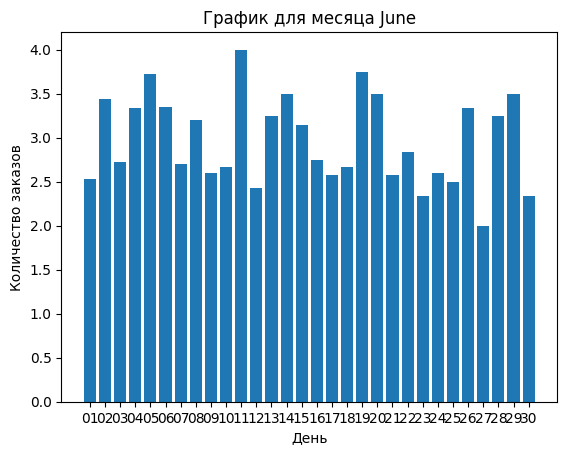

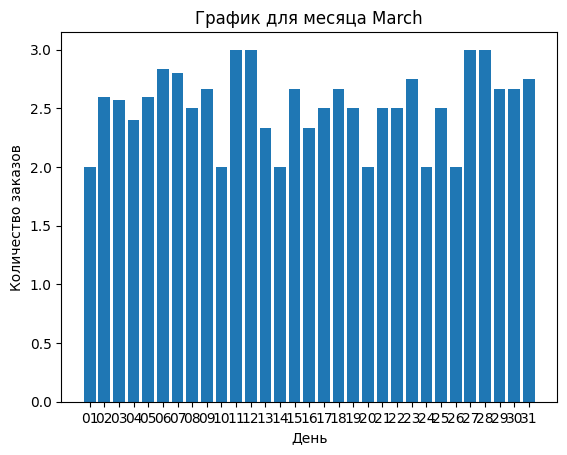

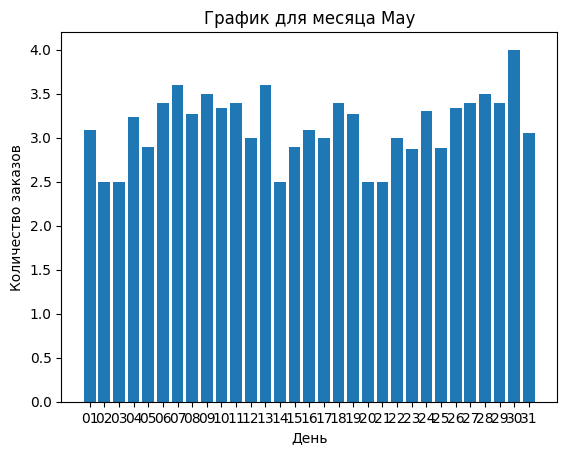

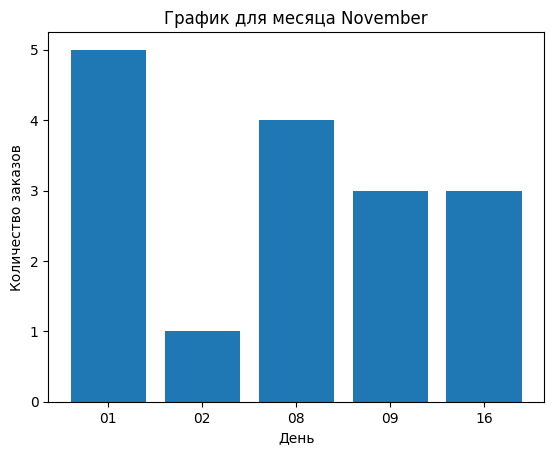

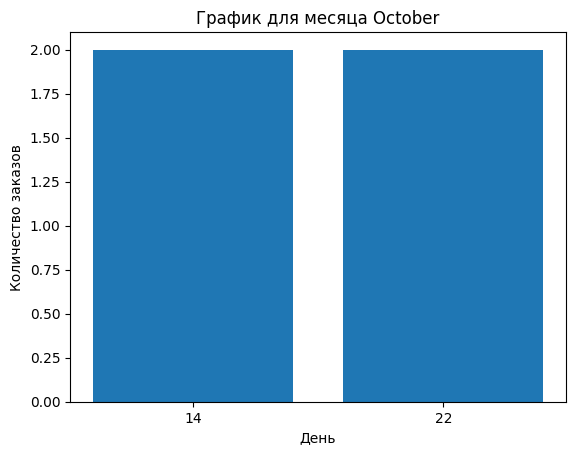

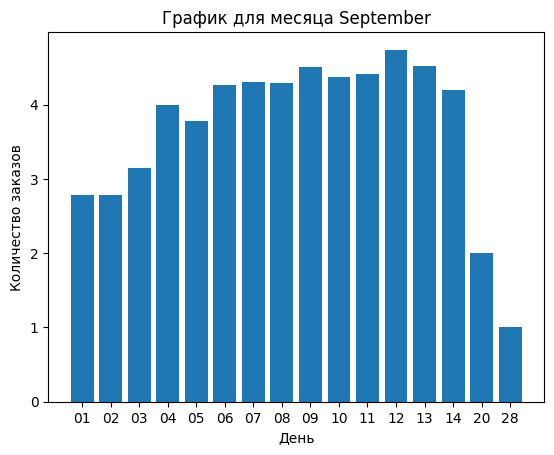

In [ ]:
grouped_data = df.groupby('month')

for month, data in grouped_data:
    daily_mean = data.groupby('day')['target'].mean()

    plt.bar(daily_mean.index, daily_mean.values)

    plt.xlabel('День')
    plt.ylabel('Количество заказов')
    plt.title(f'График для месяца {month}')

    plt.show()

Из графиков выше видим, что самым прибыльным для компании является сентябрь, самым плохим - октябрь(это и оправдывает среднее значение отзывов в этом месяце)
При этом самые богатые дни по переводам: 7 сентября (день пива), 31 мая, 7 июня(день шоколадного мороженного), 31 Июня, 1 Февраля, 31 Августа (подготовка перед первым сентября). То есть в праздничные дни, а также в конце месяца, люди чаще всего оставляют отзывы переводы, а следовательно, больше всего делают переводов. Оценивая рейтинги этих дней, придем к выводу, что компании стоит улучшить обслуживание в эти дни

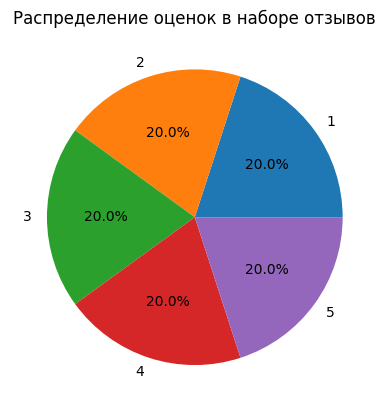

In [ ]:
estimate_counts = clean_data["target"].value_counts()

plt.pie(estimate_counts, labels=estimate_counts.index, autopct='%1.1f%%')
plt.title('Распределение оценок в наборе отзывов')
plt.show()

Классы сбалансированы

## **Обучение моделей классификации отзывов**

In [ ]:
month_mapping = {'January': 1, 'February': 2, 'March': 3,
                 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                 'August': 8, 'September': 9, 'October': 10, 'November': 11,
                 'December': 12}


clean_data['month'] = clean_data['month'].map(month_mapping)
clean_data = clean_data.sample(frac=1).reset_index(drop=True)
clean_data.head()

,review,target,month,day,year,tokens
0,you're making transfer too convolutedyou're ma...,2,NaN,10,2023,"[you, re, making, transfer, too, convolutedyou..."
1,you guys are raising the pricesyou guys are ra...,2,NaN,01,2023,"[you, guys, are, raising, the, pricesyou, guys..."
2,the app is very easy to usethe app is very eas...,5,NaN,01,2023,"[the, app, is, very, easy, to, usethe, app, is..."
3,no idea how to redeem pointsdate of experience...,3,NaN,05,2023,"[no, idea, how, to, redeem, pointsdate, of, ex..."
4,i redeemed for a 2 fee but when i sent i redee...,2,NaN,09,2023,"[i, redeemed, for, a, 2, fee, but, when, i, se..."


In [ ]:
list_feature = clean_data['review'].to_list()
list_target = clean_data['target'].to_list()

X_train, X_test, y_train, y_test = train_test_split(list_feature, list_target, random_state=1, test_size=0.2)


In [ ]:
def get_time_and_accuracy_model(model, X_train, X_test, y_train, y_test):

  start_time = time.time()

  start_training_time = time.time()
  model.fit(X_train, y_train)
  end_training_time = time.time()

  start_testing_time = time.time()
  y_pred = model.predict(X_test)
  end_testing_time = time.time()

  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

  training_time = end_training_time - start_training_time
  testing_time = end_testing_time - start_testing_time
  total_time = time.time() - start_time

  return [total_time, training_time, testing_time, accuracy]


names = ['Logistic Regression',
         'Linear SVC',
         'SVC with RBF',
         'Ridge Classifier',
         'Tree',
         'Naive Bayes',
         'Random Forest']

columns = ['Run time', 'Traing time', 'Test time', 'Accuracy']

### **TF-IDF coding**

In [ ]:
# Создание моделей
log_reg = LogisticRegression()
lin_svc = LinearSVC()
svc = SVC(kernel='rbf')
ridge = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0])
tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
ran_forest = RandomForestClassifier(n_estimators=100, max_depth=10)


In [ ]:
# Задача: нужно решить проблему с признаками, как законкатенировать tfidf и дату?
vectorizer_tfidf = TfidfVectorizer(stop_words="english")
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

models_tfidf = []

In [ ]:
# First model: Logistic Regression
models_tfidf.append(get_time_and_accuracy_model(log_reg, X_train_tfidf,
                                                X_test_tfidf, y_train, y_test))
# Second model: Linear SVC
models_tfidf.append(get_time_and_accuracy_model(lin_svc, X_train_tfidf,
                                                X_test_tfidf, y_train, y_test))
# Third model: SVC with RBF
models_tfidf.append(get_time_and_accuracy_model(svc, X_train_tfidf,
                                                X_test_tfidf, y_train, y_test))
# Fourth model: Ridge Classifier
models_tfidf.append(get_time_and_accuracy_model(ridge, X_train_tfidf,
                                                X_test_tfidf, y_train, y_test))
# Fifth model: Tree
models_tfidf.append(get_time_and_accuracy_model(tree, X_train_tfidf,
                                                X_test_tfidf, y_train, y_test))
# Sixth model: Naive Bayes
models_tfidf.append(get_time_and_accuracy_model(naive_bayes,
                                                X_train_tfidf.toarray(),
                                                X_test_tfidf.toarray(),
                                                y_train, y_test))
# Seventh model: Random Forest
models_tfidf.append(get_time_and_accuracy_model(ran_forest, X_train_tfidf,
                                                X_test_tfidf, y_train, y_test))

Accuracy: 0.5346153846153846
Accuracy: 0.5057692307692307
Accuracy: 0.5480769230769231
Accuracy: 0.5230769230769231
Accuracy: 0.42115384615384616
Accuracy: 0.3019230769230769
Accuracy: 0.4519230769230769


In [ ]:
accuracy_tfidf = pd.DataFrame(models_tfidf, index=names, columns=columns).round(4)
accuracy_tfidf

,Run time,Traing time,Test time,Accuracy
Logistic Regression,1.8971,1.8898,0.0007,0.5346
Linear SVC,0.1248,0.1216,0.0006,0.5058
SVC with RBF,2.5354,2.0877,0.4409,0.5481
Ridge Classifier,9.1063,9.1033,0.0006,0.5231
Tree,0.2471,0.2446,0.0008,0.4212
Naive Bayes,0.2456,0.1640,0.0800,0.3019
Random Forest,0.3499,0.3348,0.0134,0.4519


### **Bag of words coding**

In [ ]:
# Создание моделей
log_reg = LogisticRegression(max_iter=2000)
lin_svc = LinearSVC()
svc = SVC(kernel='rbf')
ridge = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0])
tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
ran_forest = RandomForestClassifier(n_estimators=100, max_depth=10)

In [ ]:
vectorizer_bow = CountVectorizer(stop_words="english")
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

models_bow = []

In [ ]:
# First model: Logistic Regression
models_bow.append(get_time_and_accuracy_model(log_reg, X_train_bow,
                                                X_test_bow, y_train, y_test))
# Second model: Linear SVC
models_bow.append(get_time_and_accuracy_model(lin_svc, X_train_bow,
                                                X_test_bow, y_train, y_test))
# Third model: SVC with RBF
models_bow.append(get_time_and_accuracy_model(svc, X_train_bow,
                                                X_test_bow, y_train, y_test))
# Fourth model: Ridge Classifier
models_bow.append(get_time_and_accuracy_model(ridge, X_train_bow,
                                                X_test_bow, y_train, y_test))
# Fifth model: Tree
models_bow.append(get_time_and_accuracy_model(tree, X_train_bow,
                                                X_test_bow, y_train, y_test))
# Sixth model: Naive Bayes
models_bow.append(get_time_and_accuracy_model(naive_bayes,
                                                X_train_bow.toarray(),
                                                X_test_bow.toarray(),
                                                y_train, y_test))
# Seventh model: Random Forest
models_bow.append(get_time_and_accuracy_model(ran_forest, X_train_bow,
                                                X_test_bow, y_train, y_test))

Accuracy: 0.5365384615384615
Accuracy: 0.49230769230769234
Accuracy: 0.525
Accuracy: 0.5076923076923077
Accuracy: 0.4576923076923077
Accuracy: 0.31153846153846154
Accuracy: 0.46153846153846156


In [ ]:
accuracy_bow = pd.DataFrame(models_bow, index=names, columns=columns).round(4)
accuracy_bow

,Run time,Traing time,Test time,Accuracy
Logistic Regression,2.4068,2.4003,0.0006,0.5365
Linear SVC,0.3739,0.3706,0.0005,0.4923
SVC with RBF,2.0997,1.7395,0.3571,0.5250
Ridge Classifier,7.3867,7.3839,0.0008,0.5077
Tree,0.3559,0.3521,0.0010,0.4577
Naive Bayes,0.3976,0.2823,0.1125,0.3115
Random Forest,0.7659,0.6886,0.0665,0.4615


### **N-gramms coding**

In [ ]:
# Создание моделей
log_reg = LogisticRegression()
lin_svc = LinearSVC()
svc = SVC(kernel='rbf')
ridge = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0])
tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
ran_forest = RandomForestClassifier(n_estimators=100, max_depth=10)

In [ ]:
vectorizer_n_gramms = CountVectorizer(ngram_range=(2, 2), stop_words="english")
X_train_n_gramms = vectorizer_n_gramms.fit_transform(X_train)
X_test_n_gramms = vectorizer_n_gramms.transform(X_test)

models_n_gramms = []

In [ ]:
# First model: Logistic Regression
models_n_gramms.append(get_time_and_accuracy_model(log_reg, X_train_n_gramms,
                                                X_test_n_gramms, y_train, y_test))
# Second model: Linear SVC
models_n_gramms.append(get_time_and_accuracy_model(lin_svc, X_train_n_gramms,
                                                X_test_n_gramms, y_train, y_test))
# Third model: SVC with RBF
models_n_gramms.append(get_time_and_accuracy_model(svc, X_train_n_gramms,
                                                X_test_n_gramms, y_train, y_test))
# Fourth model: Ridge Classifier
models_n_gramms.append(get_time_and_accuracy_model(ridge, X_train_n_gramms,
                                                X_test_n_gramms, y_train, y_test))
# Fifth model: Tree
models_n_gramms.append(get_time_and_accuracy_model(tree, X_train_n_gramms,
                                                X_test_n_gramms, y_train, y_test))
# Sixth model: Naive Bayes
models_n_gramms.append(get_time_and_accuracy_model(naive_bayes,
                                                X_train_n_gramms.toarray(),
                                                X_test_n_gramms.toarray(),
                                                y_train, y_test))
# Seventh model: Random Forest
models_n_gramms.append(get_time_and_accuracy_model(ran_forest, X_train_n_gramms,
                                                X_test_n_gramms, y_train, y_test))

Accuracy: 0.5019230769230769
Accuracy: 0.45384615384615384
Accuracy: 0.4076923076923077
Accuracy: 0.4980769230769231
Accuracy: 0.4269230769230769
Accuracy: 0.3903846153846154
Accuracy: 0.4403846153846154


In [ ]:
accuracy_n_gramms = pd.DataFrame(models_n_gramms, index=names, columns=columns).round(4)
accuracy_n_gramms

,Run time,Traing time,Test time,Accuracy
Logistic Regression,3.0894,3.0825,0.0012,0.5019
Linear SVC,0.1212,0.1198,0.0004,0.4538
SVC with RBF,1.3414,1.1914,0.1491,0.4077
Ridge Classifier,6.4164,6.4093,0.0006,0.4981
Tree,1.1229,1.1193,0.0011,0.4269
Naive Bayes,1.6753,1.1543,0.5184,0.3904
Random Forest,0.5178,0.4954,0.0198,0.4404


## **Итоги**

По результатам тренировки лучше всего себя показали модели: LogisticRegresion на наборе TF-IDF и BOW, а также SVC with RBF на наборе TF_IDF. Проанализируем их, через classification_report.

In [ ]:
log_reg_tfidf = LogisticRegression()

log_reg_tfidf.fit(X_train_tfidf, y_train)
y_pred = log_reg_tfidf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.52      0.65      0.58       107
           2       0.40      0.44      0.42       102
           3       0.48      0.32      0.38       125
           4       0.53      0.60      0.56        94
           5       0.79      0.73      0.76        92

    accuracy                           0.53       520
   macro avg       0.54      0.55      0.54       520
weighted avg       0.54      0.53      0.53       520



In [ ]:
log_reg_bow = LogisticRegression(max_iter=2000)

log_reg_bow.fit(X_train_bow, y_train)
y_pred = log_reg_bow.predict(X_test_bow)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.56      0.62      0.59       107
           2       0.40      0.44      0.42       102
           3       0.46      0.28      0.35       125
           4       0.53      0.65      0.58        94
           5       0.73      0.78      0.76        92

    accuracy                           0.54       520
   macro avg       0.54      0.55      0.54       520
weighted avg       0.53      0.54      0.53       520



In [ ]:
svc = SVC(kernel='rbf')

svc.fit(X_train_bow, y_train)
y_pred = svc.predict(X_test_bow)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.52      0.70      0.60       107
           2       0.46      0.42      0.44       102
           3       0.52      0.24      0.33       125
           4       0.43      0.69      0.53        94
           5       0.80      0.65      0.72        92

    accuracy                           0.53       520
   macro avg       0.55      0.54      0.52       520
weighted avg       0.54      0.53      0.51       520



Анализируя результаты, можно заметить, что модель неплохо определяет оценку 5 и 1, остальные классы отстают. Вывод: нужно добавить отзывы с оценкой 2, 3, 4

## **Проверка результатов**

In [ ]:
def testing_models():

  def standardize_sentence(review):
    review = review.replace(r"http\S+", "")
    review = review.replace(r"http", "")
    review = review.replace(r"@\S+", "")
    review = review.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    review = review.replace(r"@", "at")
    review = review.replace(r"\s+", " ")
    review = review.lower()
    return review

  review = [standardize_sentence(input('Напишите отзыв: '))]

  test_tfidf = vectorizer_tfidf.transform(review)
  test_bow = vectorizer_bow.transform(review)

  print(f'По первой модели оценка: {log_reg_tfidf.predict(test_tfidf)[0]}\n')
  print(f'По второй модели оценка: {log_reg_bow.predict(test_bow)[0]}\n')
  print(f'По третьей модели оценка: {svc.predict(test_tfidf)[0]}\n')

In [ ]:
testing_models()

Напишите отзыв: Was Simple and easy on the App no waiting in lines and no hassle of finding a Western Union store
По первой модели оценка: 5

По второй модели оценка: 4

По третьей модели оценка: 4



Первая модель угадала, остальные нет, но были близки

In [ ]:
testing_models()

Напишите отзыв: Western Union is one of the best ways to transfer money to your loved one’s. Very reliable and always on time!
По первой модели оценка: 5

По второй модели оценка: 4

По третьей модели оценка: 4



Угадала опять первая модель

In [ ]:
testing_models()

Напишите отзыв: The service is good, however, the days it takes for the receiver to pick too long. I wish it was 2 days rather than 4 days.
По первой модели оценка: 3

По второй модели оценка: 3

По третьей модели оценка: 4



Угадала только последняя модель

In [ ]:
testing_models()

Напишите отзыв: Easy to use once it is setup 👌
По первой модели оценка: 4

По второй модели оценка: 4

По третьей модели оценка: 4



Все трим модели угадали результат

In [ ]:
testing_models()

Напишите отзыв: I’m from Jamaica my only means to send Money to bill my house in Jamaica is western union, is not everyone a thief I’m a Hard-working woman trying to bill my dream house You guys block me all the time
По первой модели оценка: 2

По второй модели оценка: 2

По третьей модели оценка: 4



Не угадал никто (оценка 3)

Угадала только последняя модель, остальные ошиблись сильно, видимо эти две модели, оценивают длину, так как в прошлом отзыве они ответили верно

In [ ]:
testing_models()

Напишите отзыв: It is inconvenient to use point credit on the app. It is inconvenient to use point credit. It would be great if I could see available point credit when I send money using mobile app. That has been my major comment for years.
По первой модели оценка: 2

По второй модели оценка: 2

По третьей модели оценка: 4



Опять не угадал никто... Последней модели стоит поставить штраф за 4-ку

In [ ]:
testing_models()

Напишите отзыв: They said that I gonna get FREE… They said that I gonna get FREE transation, but they charge me $7.99
По первой модели оценка: 3

По второй модели оценка: 3

По третьей модели оценка: 4



In [ ]:
Никто не угадал, ответ 2

In [ ]:
testing_models()

Напишите отзыв: The app stop The app stop, I had to refresh twice the page
По первой модели оценка: 2

По второй модели оценка: 2

По третьей модели оценка: 4



Оценка 2 угадали 2 верхнии модели. Опять 4...

In [ ]:
testing_models()

Напишите отзыв: My payment is still pending after 6… My payment is still pending after 6 days. Rang WU twice, escalated the issue, still pending.  Clearly an attempt by this organisation to hold funds longer than needed, for financial gain!  Disgrace!
По первой модели оценка: 3

По второй модели оценка: 3

По третьей модели оценка: 4



Оценка 1, не угадал никто

In [ ]:
testing_models()

Напишите отзыв: Firstly I appreciate you watching out… Firstly I appreciate you watching out for fraud but for you to make that judgment for me is an insult to me. I consider myself an intelligent 67 year old male that knows what he is doing. I know my receiver extremely well and have copies of all her important personal documents including passport. We have applied for a K1visa with the USCIS and have our NOA1 reference number. So while waiting for the process for my receiver to be able to come to the USA I need to support her and develop our plans together here and there. As you know everything takes money so I need to be able to send money without being questioned and hassled as this causes great stress to myself and my receiver. The gentleman (Ray) that I talked with about my last transaction seemed to be much more empathetic and understanding about my explanation of why I say that I’m not a victim of fraud and I was able to get my transaction done. I’ve had some transactions denie

Первый две модели угадали, последняя продолжает ставить 4-ку...